Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [x] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [x] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [x] Do one-hot encoding of categorical features.
- [x] Do feature selection with `SelectKBest`.
- [x] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [x] Get mean absolute error for the test set.
- [x] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Linear-Models/data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

<ipython-input-2-af795232c33e>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['SALE_PRICE']


In [3]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [4]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [5]:
# Model Building
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt

# For encoding categorical data
from category_encoders import OneHotEncoder

## Wrangle Data

In [6]:
def wrangle(filepath):
    # Read New York City property sales data
    df = pd.read_csv(filepath, parse_dates = ['SALE DATE'], index_col = 'SALE DATE')

    # Change column names: replace spaces with underscores
    df.columns = [col.replace(' ', '_') for col in df]

    # SALE_PRICE was read as strings.
    # Remove symbols, convert to integer
    df['SALE_PRICE'] = (df['SALE_PRICE'].str.replace('$','').str.replace('-','').str.replace(',','').astype(int))
    
    # BOROUGH is a numeric column, but arguably should be a categorical feature,
    # so convert it from a number to a string
    df['BOROUGH'] = df['BOROUGH'].astype(str)
    
    # Reduce cardinality for NEIGHBORHOOD feature

    # Get a list of the top 10 neighborhoods
    top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

    # At locations where the neighborhood is NOT in the top 10, 
    # replace the neighborhood with 'OTHER'
    df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
    
    # Remove high-cardinality categorical variables
    cutoff = 50
    drop_cols = [col for col in df.select_dtypes('object') if df[col].nunique() > cutoff]
    df.drop(columns = drop_cols, inplace = True)
    
    return df

In [7]:
# Apply wrangle function
df = wrangle(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

<ipython-input-6-33efbe81ea25>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['SALE_PRICE'] = (df['SALE_PRICE'].str.replace('$','').str.replace('-','').str.replace(',','').astype(int))


In [8]:
df.tail()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
SALE DATE,,,,,,,,,,,,,,,
2019-04-30,4,OTHER,01 ONE FAMILY DWELLINGS,1,10965,276,NaN,11429.0,1.0,0.0,1.0,1224.0,1945.0,1,510000
2019-04-30,4,OTHER,09 COOPS - WALKUP APARTMENTS,2,169,29,NaN,11104.0,0.0,0.0,0.0,0.0,1929.0,2,355000
2019-04-30,4,OTHER,10 COOPS - ELEVATOR APARTMENTS,2,131,4,NaN,11377.0,0.0,0.0,0.0,0.0,1932.0,2,375000
2019-04-30,4,OTHER,02 TWO FAMILY DWELLINGS,1,8932,18,NaN,11421.0,2.0,1.0,3.0,2200.0,1931.0,1,1100000
2019-04-30,4,OTHER,12 CONDOS - WALKUP APARTMENTS,2,1216,1161,NaN,11377.0,1.0,0.0,85.0,854.0,1927.0,2,569202


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23040 entries, 2019-01-01 to 2019-04-30
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BOROUGH                    23040 non-null  object 
 1   NEIGHBORHOOD               23040 non-null  object 
 2   BUILDING_CLASS_CATEGORY    23040 non-null  object 
 3   TAX_CLASS_AT_PRESENT       23039 non-null  object 
 4   BLOCK                      23040 non-null  int64  
 5   LOT                        23040 non-null  int64  
 6   EASE-MENT                  0 non-null      float64
 7   ZIP_CODE                   23039 non-null  float64
 8   RESIDENTIAL_UNITS          23039 non-null  float64
 9   COMMERCIAL_UNITS           23039 non-null  float64
 10  TOTAL_UNITS                23039 non-null  float64
 11  GROSS_SQUARE_FEET          23039 non-null  float64
 12  YEAR_BUILT                 23005 non-null  float64
 13  TAX_CLASS_AT_TIME_OF_SALE  23

In [10]:
df['EASE-MENT'].unique()

array([nan])

In [11]:
# Subset df with the specifications from assignment (1 fam dwellings and price range of 100k to 2M)
# Dropping EASE-MENT because it is all NaN
df = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & 
        (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)].drop(columns = 'EASE-MENT')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3151 entries, 2019-01-01 to 2019-04-30
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BOROUGH                    3151 non-null   object 
 1   NEIGHBORHOOD               3151 non-null   object 
 2   BUILDING_CLASS_CATEGORY    3151 non-null   object 
 3   TAX_CLASS_AT_PRESENT       3151 non-null   object 
 4   BLOCK                      3151 non-null   int64  
 5   LOT                        3151 non-null   int64  
 6   ZIP_CODE                   3151 non-null   float64
 7   RESIDENTIAL_UNITS          3151 non-null   float64
 8   COMMERCIAL_UNITS           3151 non-null   float64
 9   TOTAL_UNITS                3151 non-null   float64
 10  GROSS_SQUARE_FEET          3151 non-null   float64
 11  YEAR_BUILT                 3151 non-null   float64
 12  TAX_CLASS_AT_TIME_OF_SALE  3151 non-null   int64  
 13  SALE_PRICE                 315

The cells below are the code I ran during EDA to drop high-cardinality categorical variables.

In [13]:
# df.select_dtypes('object').nunique()

In [14]:
# df['BOROUGH'].nunique()

In [15]:
# PRAC = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')
# PRAC['BUILDING CLASS CATEGORY'].nunique()

In [16]:
# df['TAX_CLASS_AT_PRESENT'].nunique()

## Split Data

In [17]:
# split data into feature matrix and target vector
target = 'SALE_PRICE'
y = df[target]
X = df.drop(columns = target)

In [18]:
# split data into training and test sets
cutoff = '2019-04-01'
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

## Establish Baseline

In [19]:
y_pred = [y_train.mean()] * len(y_train)
print('Mean price:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean price: 621573.7423214999
Baseline MAE: 214721.52773001452


## Build Models

In [20]:
# Import transformer class...did it above

# Instantiate transformer
ohe = OneHotEncoder(use_cat_names = True)

# Fit transformer to training data
ohe.fit(X_train)

# Transform training and test data
XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)

/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Linear-Models/unit2venv/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


**Model 1:** Linear Regression (Plain old LR)

In [54]:
# Instantiate class
model_lr = LinearRegression(normalize=True)

# Fit model
model_lr.fit(XT_train, y_train)

LinearRegression(normalize=True)

**Model 2:** Ridge Regression (Regularization)

In [24]:
# Instantiate class
model_r = Ridge(alpha = 1.0)

# Fit model
model_r.fit(XT_train, y_train)

Ridge()

**Model 3:** SelectKBest

In [44]:
# Instantiate transformer
skb = SelectKBest(f_regression, k = 15)

# Fit transformer to training data
skb.fit(XT_train, y_train)

# Transform training and test data
XTT_train = skb.transform(XT_train)
XTT_test = skb.transform(XT_test)

# Instantiate class
model_lr2 = LinearRegression()

# Fit model with transformed training set
model_lr2.fit(XTT_train, y_train)

LinearRegression()

## Check Metrics

Checking Model 1's Metrics

In [22]:
print('LR training MAE:', mean_absolute_error(y_train, model_lr.predict(XT_train)))
print('LR test MAE:', mean_absolute_error(y_test, model_lr.predict(XT_test)))

LR training MAE: 156330.2446703739
LR test MAE: 160586.94040065832


Checking Model 2's Metrics

In [55]:
print('Ridge training MAE:', mean_absolute_error(y_train, model_r.predict(XT_train)))
print('Ridge test MAE:', mean_absolute_error(y_test, model_r.predict(XT_test)))

Ridge training MAE: 156346.5337290741
Ridge test MAE: 160506.64794815847


Checking Model 3's Metrics

In [45]:
print('LR training with SKB MAE:', mean_absolute_error(y_train, model_lr2.predict(XTT_train)))
print('LR training with SKB MAE:', mean_absolute_error(y_test, model_lr2.predict(XTT_test)))

LR training with SKB MAE: 158025.33982107847
LR training with SKB MAE: 160122.580453062


## Communicating Results

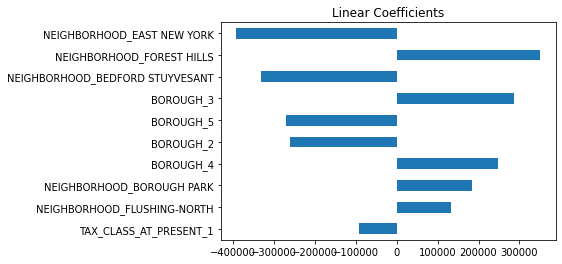

In [23]:
feature_names = ohe.get_feature_names()
coefficients = model_lr.coef_
feature_importances = pd.Series(coefficients, index = feature_names).sort_values(key = abs)
feature_importances.tail(10).plot(kind = 'barh', title = 'Linear Coefficients');

<AxesSubplot:title={'center':'Ridge Coefficients'}>

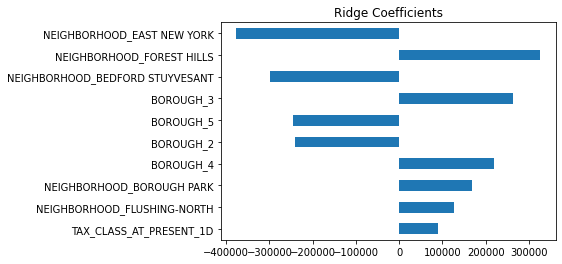

In [27]:
feature_names = ohe.get_feature_names()
coefficients_r = model_r.coef_
feature_importances_r = pd.Series(coefficients_r, index = feature_names).sort_values(key = abs)
feature_importances_r.tail(10).plot(kind = 'barh', title = 'Ridge Coefficients')